<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Семинар-2.-PyTorch.-Оптимизаторы" data-toc-modified-id="Семинар-2.-PyTorch.-Оптимизаторы-0.1"><span class="toc-item-num">0.1&nbsp;&nbsp;</span><b>Семинар 2. PyTorch. Оптимизаторы</b></a></span></li></ul></li><li><span><a href="#Загрузка-датасета" data-toc-modified-id="Загрузка-датасета-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Загрузка датасета</a></span></li><li><span><a href="#Код-обучения" data-toc-modified-id="Код-обучения-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Код обучения</a></span></li><li><span><a href="#Adam" data-toc-modified-id="Adam-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Adam</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Adam,-применение-в-PyTorch" data-toc-modified-id="Adam,-применение-в-PyTorch-3.0.1"><span class="toc-item-num">3.0.1&nbsp;&nbsp;</span>Adam, применение в PyTorch</a></span></li></ul></li></ul></li><li><span><a href="#Weight-Decay" data-toc-modified-id="Weight-Decay-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Weight Decay</a></span></li><li><span><a href="#LR-scheduling" data-toc-modified-id="LR-scheduling-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>LR scheduling</a></span></li><li><span><a href="#Что-мы-сегодня-сделали?" data-toc-modified-id="Что-мы-сегодня-сделали?-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Что мы сегодня сделали?</a></span><ul class="toc-item"><li><span><a href="#Что-еще-стоит-почитать" data-toc-modified-id="Что-еще-стоит-почитать-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>Что еще стоит почитать</a></span></li></ul></li></ul></div>

<h2 style="text-align: center;"><b>Семинар 2. PyTorch. Оптимизаторы</b></h2>


In [1]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from torchvision import transforms, utils, datasets

from tqdm.notebook import tqdm

sns.set(style="darkgrid", font_scale=1.4)

Каждый тензор находится в памяти какого-то устройства. По умолчанию все тензоры находятся в оперативной памяти, а все операции над ними совершаются с помощью процессора. Если обучать нейросети на процессоре, то вы будете очень долго ждать. Обычно все современные архитектуры требуют наличия мощных видеокарт, которые ускоряют все вычисления до 100 раз. 

Чтобы включить видеокарту в Colab нужно пройти по **Runtime** -> **Change Runtime Type** -> **выбрать GPU и подтвердить действия**. Ваш ноутбук сбросится и далее вам будет доступна видеокарта.

Чтобы перенести обучение на видеокарту, нам нужно будет выполнить 

```python
model = model.to('cuda')
```

И далее для всех тензоров, которые мы передаем в модель надо сделать то же самое.


```python
X_batch = X_batch.to('cuda')
y_batch = y_batch.to('cuda')
```

In [2]:
device = torch.device('cuda:0') if torch.cuda.is_available else torch.device('cpu')
device

device(type='cuda', index=0)

# Загрузка датасета


In [3]:
def get_dataloaders(batch_size):
    transform = transforms.ToTensor()
    
    trainset = datasets.MNIST(root='./data', train=True,
                                            download=True, transform=transform)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                              shuffle=True, num_workers=2)
    testset = datasets.MNIST(root='./data', train=False,
                                           download=True, transform=transform)
    testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                             shuffle=False, num_workers=2)
    return trainloader, testloader

In [4]:
BATCH_SIZE = 10
train_dl, test_dl = get_dataloaders(BATCH_SIZE)

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


В PyTorch датасетом считается любой объект, для которого определены методы `__len__(self)` и `__getitem__(self, i)`.

# Код обучения

In [5]:
def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    train_losses = []
    val_losses = []
    valid_accuracies = []
    for epoch in range(epochs):
        model.train()
        loss_sum = 0
        for X_batch, y_batch in tqdm(train_dl):
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            loss = loss_func(model(X_batch), y_batch)
            loss_sum += loss.item()
            
            loss.backward()
            opt.step()
            opt.zero_grad()
        train_losses.append(loss_sum / len(train_dl))

        model.eval()
        loss_sum = 0
        correct = 0
        num = 0
        with torch.no_grad():
            for X_batch, y_batch in valid_dl:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                probs = model(X_batch)
                loss_sum += loss_func(probs, y_batch).item()
                
                _, preds = torch.max(probs, axis=-1)
                correct += (preds == y_batch).sum().item()
                num += len(X_batch)
                
        val_losses.append(loss_sum / len(valid_dl))
        valid_accuracies.append(correct / num)
        
    return train_losses, val_losses, valid_accuracies

In [6]:
def plot_trainig(train_losses, valid_losses, valid_accuracies):
    plt.figure(figsize=(12, 9))
    plt.subplot(2, 1, 1)
    plt.xlabel('epoch')
    plt.plot(train_losses, label='train_loss')
    plt.plot(valid_losses, label='valid_loss')
    plt.legend()
    
    plt.subplot(2, 1, 2)
    plt.xlabel('epoch')
    plt.plot(valid_accuracies, label='valid accuracy')
    plt.legend()

In [7]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 120) 
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

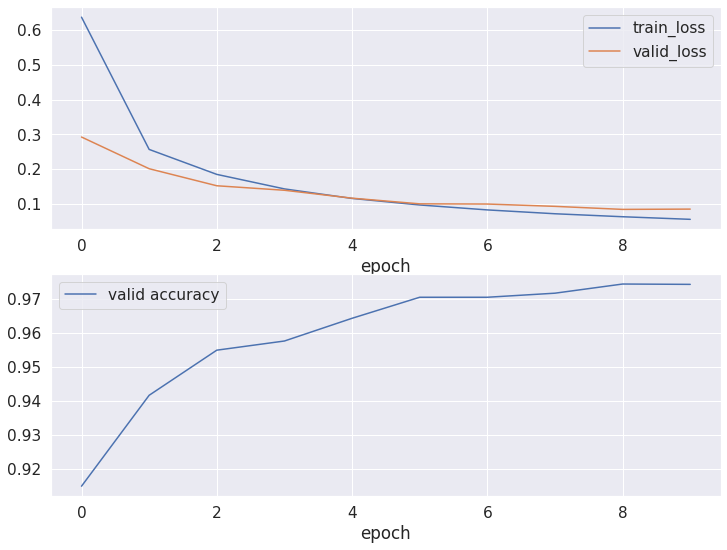

In [8]:
model = Model().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

info = fit(10, model, criterion, optimizer, train_dl, test_dl)
plot_trainig(*info)

# Adam

Это самый популярный оптимизатор для нейронных сетей. Если вам интересны сравнения разных алгоритмов, то можете почитать эту статью https://arxiv.org/abs/1609.04747.

### Adam, применение в PyTorch

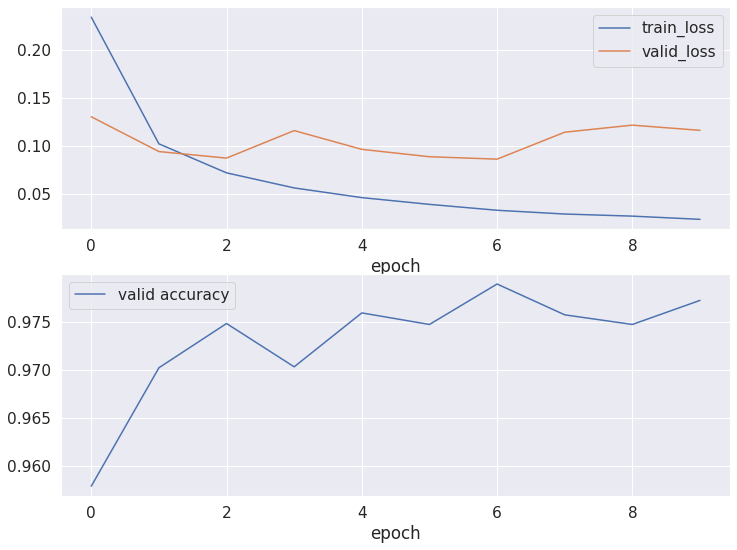

In [9]:
model = Model().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999))

info = fit(10, model, criterion, optimizer, train_dl, test_dl)
plot_trainig(*info)

# Weight Decay

Для регуляризации линейных моделей мы прибавляли к лоссу сумму квадратов весов, умноженных на некоторый коэффициент:
$$L(\mathbf{w})=\sum_{i=1}^{l}\left(\mathbf{x}_{i}^{T} \mathbf{w}-y_{i}\right)^{2}+\beta \sum_{j=1}^{n} w_{j}^{2}$$

Для нейронных сетей мы можем выбрать такую же реугляризацию. Она называется WeightDecay. Во многие оптимизаторы можно передать параметр `weight_decay` и он будет являться коэффициентом, на который домножается сумма квадратовв весов.

Обычно используют weight_decay=0.01 или 0.005.

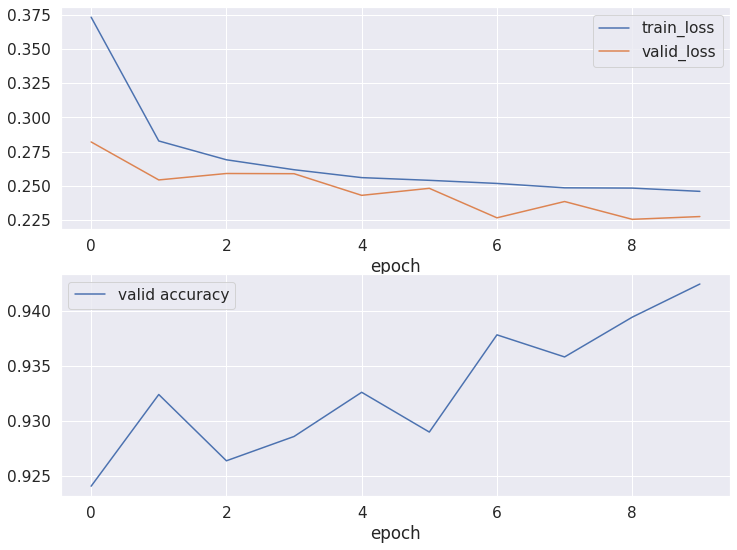

In [10]:
model = Model().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), weight_decay=0.01)

info = fit(10, model, criterion, optimizer, train_dl, test_dl)
plot_trainig(*info)

# LR scheduling

Часто мы хотим, чтобы наш learning rate как-то изменялся во время обучения. Стратегия, по которой мы будем изменять lr называется lr scheduilng.

Например, мы можем хотеть, чтобы learning_rate уменьшался с каждой эпохой в фиксированное число раз. Тогда в начале мы будем быстро двигаться к минимуму, а в конце точно не промахнемся мимо него за счет малых шагов. Такая стратегия называется LR Decay.
![](https://www.deeplearningwizard.com/deep_learning/boosting_models_pytorch/images/lr2.png)

(Слева используется lr decay, справа нет. Слева мы можем не подбирать идеально точно lr и все равно со временем сойтись.)

Нам нужно немного изменить train loop

In [11]:
def fit(epochs, model, loss_func, opt, train_dl, valid_dl, lr_sched=None):
    train_losses = []
    val_losses = []
    valid_accuracies = []
    for epoch in range(epochs):
        model.train()
        loss_sum = 0
        for X_batch, y_batch in tqdm(train_dl):
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            loss = loss_func(model(X_batch), y_batch)
            loss_sum += loss.item()
            
            loss.backward()
            opt.step()
            opt.zero_grad()
        train_losses.append(loss_sum / len(train_dl))

        model.eval()
        loss_sum = 0
        correct = 0
        num = 0
        with torch.no_grad():
            for X_batch, y_batch in valid_dl:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                probs = model(X_batch)
                loss_sum += loss_func(probs, y_batch).item()
                
                _, preds = torch.max(probs, axis=-1)
                correct += (preds == yb).sum().item()
                num += len(xb)
                
        val_losses.append(loss_sum / len(valid_dl))
        valid_accuracies.append(correct / num)
        
        # CHANGES HERE
        lr_ched.step()
        # CHANGES END
        
    return train_losses, val_losses, valid_accuracies

In [ ]:
model = Model().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), weight_decay=0.01)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=0.5)

info = fit(10, model, criterion, optimizer, *get_dataloaders(4))
plot_trainig(*info)


# Что мы сегодня сделали?

* Узнали, как перемещать вычисления на GPU.
* Попробовали Adam и weight decay.

## Что еще стоит почитать

* Пройти optional ноутбук по Dropout, BatchNorm. Использовать эти приемы для нейросетей, использующих только полносвязные слои имеет мало смысла. Поэтому советую вернуться к нему, когда вы пройдете модуль по Компьютерному Зрению и узнаете про свертки. На более сложных моделях, которые появляются в этой области BatchNorm и Dropout используются почти всегда.

* Чтобы полноценно тренировать нейронные сети стоит почитать про чекпоинтинг (сохранение весов, на случай, если обучение упадет с ошибкой, или модель будет станоится хуже). Есть очень хорошее официальное руководство: https://pytorch.org/tutorials/beginner/saving_loading_models.html.

